In [1]:
import numpy as np

In [2]:
from jobflow import job, Flow

/home/geiger_j/.aiida_venvs/adis/lib/python3.10/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/geiger_j/.aiida_venvs/adis/lib/python3.10/site-packages/paramiko/transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [3]:
from aiida import load_profile

load_profile()

Profile<uuid='d106cde233334800a702a20040a6b629' name='adis'>

In [4]:
from python_workflow_definition.jobflow import write_workflow_json

In [5]:
from python_workflow_definition.aiida import load_workflow_json

In [6]:
from quantum_espresso_workflow import (
    calculate_qe as _calculate_qe, 
    generate_structures as _generate_structures, 
    get_bulk_structure as _get_bulk_structure, 
    plot_energy_volume_curve as _plot_energy_volume_curve,
)

In [7]:
workflow_json_filename = "workflow_qe_jobflow.json"

In [8]:
calculate_qe = job(_calculate_qe, data=["energy", "volume", "structure"])
generate_structures = job(_generate_structures, data=[f"s_{i}" for i in range(100)])
plot_energy_volume_curve = job(_plot_energy_volume_curve)
get_bulk_structure = job(_get_bulk_structure)

In [9]:
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [10]:
structure = get_bulk_structure(
    element="Al",
    a=4.05,
    cubic=True,
)

In [11]:
calc_mini = calculate_qe(
    working_directory="mini",
    input_dict={
        "structure": structure.output,
        "pseudopotentials": pseudopotentials,
        "kpts": (3, 3, 3),
        "calculation": "vc-relax",
        "smearing": 0.02,
    },
)

In [12]:
number_of_strains = 5
structure_lst = generate_structures(
    structure=calc_mini.output.structure,
    strain_lst=np.linspace(0.9, 1.1, number_of_strains),
)

In [13]:
job_strain_lst = []
for i in range(number_of_strains):
    calc_strain = calculate_qe(
        working_directory="strain_" + str(i),
        input_dict={
            "structure": getattr(structure_lst.output, f"s_{i}"),
            "pseudopotentials": pseudopotentials,
            "kpts": (3, 3, 3),
            "calculation": "scf",
            "smearing": 0.02,
        },
    )
    job_strain_lst.append(calc_strain)

In [14]:
plot = plot_energy_volume_curve(
    volume_lst=[job.output.volume for job in job_strain_lst],
    energy_lst=[job.output.energy for job in job_strain_lst],
)

In [15]:
flow = Flow([structure, calc_mini, structure_lst] + job_strain_lst + [plot])

In [16]:
write_workflow_json(flow=flow, file_name=workflow_json_filename)

In [17]:
!cat {workflow_json_filename}

───────┬────────────────────────────────────────────────────────────────────────
       │ File: workflow_qe_jobflow.json
───────┼────────────────────────────────────────────────────────────────────────
   1   │ {"nodes": {"0": "quantum_espresso_workflow.get_bulk_structure", "1": "q
       │ uantum_espresso_workflow.calculate_qe", "2": "quantum_espresso_workflow
       │ .generate_structures", "3": "quantum_espresso_workflow.calculate_qe", "
       │ 4": "quantum_espresso_workflow.calculate_qe", "5": "quantum_espresso_wo
       │ rkflow.calculate_qe", "6": "quantum_espresso_workflow.calculate_qe", "7
       │ ": "quantum_espresso_workflow.calculate_qe", "8": "quantum_espresso_wor
       │ kflow.plot_energy_volume_curve", "9": "Al", "10": 4.05, "11": true, "12
       │ ": "mini", "13": "python_workflow_definition.shared.get_dict", "14": {"
       │ Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}, "15": [3, 3, 3], "16": "vc-relax"
       │ , "17": 0.02, "18": [0.9, 0.9500000000000001, 1.0, 1.05, 1.1

In [18]:
wg = load_workflow_json(workflow_json_filename)

In [19]:
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'WorkGra…

In [20]:
result = wg.run()

03/21/2025 01:02:23 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/21/2025 01:02:25 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|continue_workgraph]: tasks ready to run: pickle_node10,pickle_node11,pickle_node12,pickle_node13,pickle_node15,pickle_node16,pickle_node17,pickle_node18,pickle_node19,pickle_node20,pickle_node22,pickle_node23,pickle_node25,pickle_node27,pickle_node29
03/21/2025 01:02:25 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: pickle_node10, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'value': 'Al'}


03/21/2025 01:02:26 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: pickle_node11, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'value': 4.05}


03/21/2025 01:02:28 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: pickle_node12, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'value': True}


03/21/2025 01:02:30 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: pickle_node13, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'value': 'mini'}


03/21/2025 01:02:31 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: pickle_node15, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'value': {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}}


03/21/2025 01:02:33 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: pickle_node16, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'value': [3, 3, 3]}


03/21/2025 01:02:35 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: pickle_node17, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'value': 'vc-relax'}


03/21/2025 01:02:36 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: pickle_node18, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'value': 0.02}


03/21/2025 01:02:38 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: pickle_node19, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'value': [0.9, 0.95, 1.0, 1.05, 1.1]}


03/21/2025 01:02:40 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: pickle_node20, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'value': 'strain_0'}


03/21/2025 01:02:41 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: pickle_node22, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'value': 'scf'}


03/21/2025 01:02:43 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: pickle_node23, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'value': 'strain_1'}


03/21/2025 01:02:45 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: pickle_node25, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'value': 'strain_2'}


03/21/2025 01:02:46 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: pickle_node27, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'value': 'strain_3'}


03/21/2025 01:02:48 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: pickle_node29, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'value': 'strain_4'}


03/21/2025 01:02:52 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 13302, 13310, 13318, 13326, 13334, 13342, 13350, 13358, 13366, 13374, 13382, 13390, 13398, 13406, 13414
03/21/2025 01:03:17 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|update_task_state]: Task: pickle_node10 finished.
03/21/2025 01:03:18 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|update_task_state]: Task: pickle_node11 finished.
03/21/2025 01:03:19 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|update_task_state]: Task: pickle_node12 finished.
03/21/2025 01:03:20 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|update_task_state]: Task: pickle_node13 finished.
03/21/2025 01:03:21 PM <37

------------------------------------------------------------
kwargs:  {'a': <Float: uuid: 16afa342-6042-4610-880b-05c726ddc021 (pk: 13461) value: 4.05>, 'cubic': <Bool: uuid: e9b11d23-39ff-4906-8320-7049b9b2f899 (pk: 13462) value: True>, 'element': <Str: uuid: 74f4d149-d30e-40f5-aa5a-6f908e39df89 (pk: 13460) value: Al>, 'register_pickle_by_value': True}


03/21/2025 01:03:43 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 13481
03/21/2025 01:03:51 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|update_task_state]: Task: get_bulk_structure1 finished.
03/21/2025 01:03:57 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/21/2025 01:04:00 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_dict14
03/21/2025 01:04:00 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: get_dict14, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'calculation': <Str: uuid: 3a2f0bf2-ab76-4548-8ef8-3ea5e01e0cc7 (pk: 13466) value: vc-relax>, 'kpts': <List: uuid: de5635f7-f0c0-43cf-89cb-a924308f1f3a (pk: 13465) value: [3, 3, 3]>, 'pseudopotentials': <PickledData: uuid: 35ce5803-ed86-4244-afba-427baafeefab (pk: 13464) : {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}>, 'register_pickle_by_value': True, 'smearing': <Float: uuid: cc8c67fc-09af-4668-9184-7a2eb385defb (pk: 13467) value: 0.02>, 'structure': <Str: uuid: c09cc760-2df4-4c92-bb77-309a7d1c3317 (pk: 13485) value: {"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.05, 0.0, 0.0], [0.0, 4.05, 0.0], [0.0, 0.0, 4.05]], "space_group_symmetry_operation

03/21/2025 01:04:05 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 13492
03/21/2025 01:04:12 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|update_task_state]: Task: get_dict14 finished.
03/21/2025 01:04:17 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/21/2025 01:04:20 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|continue_workgraph]: tasks ready to run: calculate_qe2
03/21/2025 01:04:20 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: calculate_qe2, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'input_dict': <PickledData: uuid: 33d3d7be-8495-40dc-a3e7-0d4c91b96154 (pk: 13496) : {'calculation': 'vc-relax', 'kpts': [3, 3, 3], 'pseudopotentials': {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}, 'smearing': 0.02, 'structure': '{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.05, 0.0, 0.0], [0.0, 4.05, 0.0], [0.0, 0.0, 4.05]], "space_group_symmetry_operations_xyz": null, "space_group_symbol_hall": null, "space_group_symbol_hermann_mauguin": null, "space_group_symbol_hermann_mauguin_extended": null, "space_group_it_number": null, "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]], "nsites": 

03/21/2025 01:04:25 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 13503
03/21/2025 01:05:00 PM <3785899> aiida.parser.PythonJobParser: [WARNING] Found extra results that are not included in the output: dict_keys(['energy', 'volume'])
03/21/2025 01:05:01 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|update_task_state]: Task: calculate_qe2 finished.
03/21/2025 01:05:06 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/21/2025 01:05:09 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|continue_workgraph]: tasks ready to run: generate_structures3
03/21/2025 01:05:09 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks

------------------------------------------------------------
kwargs:  {'register_pickle_by_value': True, 'strain_lst': <List: uuid: 55e2d31b-9fb0-4a01-b728-e8ee98cc1621 (pk: 13468) value: [0.9, 0.95, 1.0, 1.05, 1.1]>, 'structure': <Str: uuid: 96b72e15-7a3d-406c-99a3-6985644b40fe (pk: 13507) value: {"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.045637391294343, 0.0, 0.0], [0.0, 4.045637391294343, 0.0], [0.0, 0.0, 4.045637391294343]], "space_group_symmetry_operations_xyz": null, "space_group_symbol_hall": null, "space_group_symbol_hermann_mauguin": null, "space_group_symbol_hermann_mauguin_extended": null, "space_group_it_number": null, "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 2.0228186956471714, 2.022

03/21/2025 01:05:13 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 13514
03/21/2025 01:05:22 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|update_task_state]: Task: generate_structures3 finished.
03/21/2025 01:05:27 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/21/2025 01:05:30 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|continue_workgraph]: tasks ready to run: get_dict21,get_dict24,get_dict26,get_dict28,get_dict30
03/21/2025 01:05:30 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: get_dict21, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'calculation': <Str: uuid: 635e18f9-af81-46e8-90e4-cde77339666f (pk: 13470) value: scf>, 'kpts': <List: uuid: de5635f7-f0c0-43cf-89cb-a924308f1f3a (pk: 13465) value: [3, 3, 3]>, 'pseudopotentials': <PickledData: uuid: 35ce5803-ed86-4244-afba-427baafeefab (pk: 13464) : {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}>, 'register_pickle_by_value': True, 'smearing': <Float: uuid: cc8c67fc-09af-4668-9184-7a2eb385defb (pk: 13467) value: 0.02>, 'structure': <Str: uuid: cad915e6-f342-4c37-8ba4-c85acc4b830f (pk: 13518) value: {"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[3.9060199552583, 0.0, 0.0], [0.0, 3.9060199552583, 0.0], [0.0, 0.0, 3.9060199552583]], "sp

03/21/2025 01:05:32 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: get_dict24, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'calculation': <Str: uuid: 635e18f9-af81-46e8-90e4-cde77339666f (pk: 13470) value: scf>, 'kpts': <List: uuid: de5635f7-f0c0-43cf-89cb-a924308f1f3a (pk: 13465) value: [3, 3, 3]>, 'pseudopotentials': <PickledData: uuid: 35ce5803-ed86-4244-afba-427baafeefab (pk: 13464) : {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}>, 'register_pickle_by_value': True, 'smearing': <Float: uuid: cc8c67fc-09af-4668-9184-7a2eb385defb (pk: 13467) value: 0.02>, 'structure': <Str: uuid: 82a4e574-2e70-479c-96ff-c953017478ec (pk: 13519) value: {"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[3.977054016692985, 0.0, 0.0], [0.0, 3.977054016692985, 0.0], [0.0, 0.0, 3.977054016692985]

03/21/2025 01:05:33 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: get_dict26, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'calculation': <Str: uuid: 635e18f9-af81-46e8-90e4-cde77339666f (pk: 13470) value: scf>, 'kpts': <List: uuid: de5635f7-f0c0-43cf-89cb-a924308f1f3a (pk: 13465) value: [3, 3, 3]>, 'pseudopotentials': <PickledData: uuid: 35ce5803-ed86-4244-afba-427baafeefab (pk: 13464) : {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}>, 'register_pickle_by_value': True, 'smearing': <Float: uuid: cc8c67fc-09af-4668-9184-7a2eb385defb (pk: 13467) value: 0.02>, 'structure': <Str: uuid: 1db43569-acf7-4340-9ad4-e5a38a45964d (pk: 13520) value: {"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.045637391294343, 0.0, 0.0], [0.0, 4.045637391294343, 0.0], [0.0, 0.0, 4.045637391294343]

03/21/2025 01:05:35 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: get_dict28, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'calculation': <Str: uuid: 635e18f9-af81-46e8-90e4-cde77339666f (pk: 13470) value: scf>, 'kpts': <List: uuid: de5635f7-f0c0-43cf-89cb-a924308f1f3a (pk: 13465) value: [3, 3, 3]>, 'pseudopotentials': <PickledData: uuid: 35ce5803-ed86-4244-afba-427baafeefab (pk: 13464) : {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}>, 'register_pickle_by_value': True, 'smearing': <Float: uuid: cc8c67fc-09af-4668-9184-7a2eb385defb (pk: 13467) value: 0.02>, 'structure': <Str: uuid: e06bf097-039d-4947-9939-6db78d32b643 (pk: 13521) value: {"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.111971105505518, 0.0, 0.0], [0.0, 4.111971105505518, 0.0], [0.0, 0.0, 4.111971105505518]

03/21/2025 01:05:37 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: get_dict30, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'calculation': <Str: uuid: 635e18f9-af81-46e8-90e4-cde77339666f (pk: 13470) value: scf>, 'kpts': <List: uuid: de5635f7-f0c0-43cf-89cb-a924308f1f3a (pk: 13465) value: [3, 3, 3]>, 'pseudopotentials': <PickledData: uuid: 35ce5803-ed86-4244-afba-427baafeefab (pk: 13464) : {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}>, 'register_pickle_by_value': True, 'smearing': <Float: uuid: cc8c67fc-09af-4668-9184-7a2eb385defb (pk: 13467) value: 0.02>, 'structure': <Str: uuid: 61ba84b9-1f13-4c2f-8af8-93efb425ffa4 (pk: 13522) value: {"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.176231033379921, 0.0, 0.0], [0.0, 4.176231033379921, 0.0], [0.0, 0.0, 4.176231033379921]

03/21/2025 01:05:42 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 13529, 13536, 13543, 13550, 13557
03/21/2025 01:05:54 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|update_task_state]: Task: get_dict21 finished.
03/21/2025 01:05:55 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|update_task_state]: Task: get_dict24 finished.
03/21/2025 01:05:56 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|update_task_state]: Task: get_dict26 finished.
03/21/2025 01:05:57 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|update_task_state]: Task: get_dict28 finished.
03/21/2025 01:05:58 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|W

------------------------------------------------------------
kwargs:  {'input_dict': <PickledData: uuid: 3becfc0d-76ca-4579-9c60-f575255982c4 (pk: 13573) : {'calculation': 'scf', 'kpts': [3, 3, 3], 'pseudopotentials': {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}, 'smearing': 0.02, 'structure': '{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[3.9060199552583, 0.0, 0.0], [0.0, 3.9060199552583, 0.0], [0.0, 0.0, 3.9060199552583]], "space_group_symmetry_operations_xyz": null, "space_group_symbol_hall": null, "space_group_symbol_hermann_mauguin": null, "space_group_symbol_hermann_mauguin_extended": null, "space_group_it_number": null, "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 1.95300997762915, 1.95300997762915], [1.

03/21/2025 01:06:06 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: calculate_qe5, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'input_dict': <PickledData: uuid: 6926407f-01e9-4ea5-94b8-fbdd31e9d851 (pk: 13574) : {'calculation': 'scf', 'kpts': [3, 3, 3], 'pseudopotentials': {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}, 'smearing': 0.02, 'structure': '{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[3.977054016692985, 0.0, 0.0], [0.0, 3.977054016692985, 0.0], [0.0, 0.0, 3.977054016692985]], "space_group_symmetry_operations_xyz": null, "space_group_symbol_hall": null, "space_group_symbol_hermann_mauguin": null, "space_group_symbol_hermann_mauguin_extended": null, "space_group_it_number": null, "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 1.9885270083464925, 1.988527008346

03/21/2025 01:06:08 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: calculate_qe6, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'input_dict': <PickledData: uuid: 877058f7-c7e4-4da5-a47c-3ec7d2d4046b (pk: 13575) : {'calculation': 'scf', 'kpts': [3, 3, 3], 'pseudopotentials': {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}, 'smearing': 0.02, 'structure': '{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.045637391294343, 0.0, 0.0], [0.0, 4.045637391294343, 0.0], [0.0, 0.0, 4.045637391294343]], "space_group_symmetry_operations_xyz": null, "space_group_symbol_hall": null, "space_group_symbol_hermann_mauguin": null, "space_group_symbol_hermann_mauguin_extended": null, "space_group_it_number": null, "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 2.0228186956471714, 2.022818695647

03/21/2025 01:06:10 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: calculate_qe7, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'input_dict': <PickledData: uuid: a00527c0-a412-4074-a0f5-ef8e6fa1653d (pk: 13576) : {'calculation': 'scf', 'kpts': [3, 3, 3], 'pseudopotentials': {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}, 'smearing': 0.02, 'structure': '{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.111971105505518, 0.0, 0.0], [0.0, 4.111971105505518, 0.0], [0.0, 0.0, 4.111971105505518]], "space_group_symmetry_operations_xyz": null, "space_group_symbol_hall": null, "space_group_symbol_hermann_mauguin": null, "space_group_symbol_hermann_mauguin_extended": null, "space_group_it_number": null, "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 2.055985552752759, 2.0559855527527

03/21/2025 01:06:12 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: calculate_qe8, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'input_dict': <PickledData: uuid: 5528fd29-bf91-4333-99d3-61e20bafe9cf (pk: 13577) : {'calculation': 'scf', 'kpts': [3, 3, 3], 'pseudopotentials': {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}, 'smearing': 0.02, 'structure': '{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.176231033379921, 0.0, 0.0], [0.0, 4.176231033379921, 0.0], [0.0, 0.0, 4.176231033379921]], "space_group_symmetry_operations_xyz": null, "space_group_symbol_hall": null, "space_group_symbol_hermann_mauguin": null, "space_group_symbol_hermann_mauguin_extended": null, "space_group_it_number": null, "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 2.0881155166899603, 2.088115516689

03/21/2025 01:06:16 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 13584, 13591, 13598, 13605, 13612
03/21/2025 01:07:38 PM <3785899> aiida.parser.PythonJobParser: [WARNING] Found extra results that are not included in the output: dict_keys(['structure'])
03/21/2025 01:07:39 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|update_task_state]: Task: calculate_qe4 finished.
03/21/2025 01:07:44 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/21/2025 01:07:45 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|continue_workgraph]: tasks ready to run: 
03/21/2025 01:07:48 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|on_wait]

------------------------------------------------------------
kwargs:  {'0': <PickledData: uuid: f7877f70-a5da-476d-9deb-500d14a7be2b (pk: 13625) : 59.59411400152967>, '1': <PickledData: uuid: d535a9c7-67f6-4ff9-92c3-16c7884e2516 (pk: 13628) : 62.90489811272598>, '2': <PickledData: uuid: e488134f-b52c-4d52-8245-937bd8ddb110 (pk: 13631) : 66.2156822239217>, '3': <PickledData: uuid: ada9a8e6-40e4-4e48-b2ba-e4a13d8ad96c (pk: 13634) : 69.52646633511804>, '4': <PickledData: uuid: 1fbe760e-3cd2-498c-b924-8e21a66f912b (pk: 13637) : 72.837250446314>, 'register_pickle_by_value': True}


03/21/2025 01:08:56 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|run_tasks]: Run task: get_list32, type: PYTHONJOB


------------------------------------------------------------
kwargs:  {'0': <Float: uuid: 5f2f114e-2185-4efd-8967-fa3b6f1a50ee (pk: 13624) value: -1074.8457448491>, '1': <Float: uuid: 460312fe-1cb1-4598-9b89-c696fab173d8 (pk: 13627) value: -1074.916148965>, '2': <Float: uuid: 7e4ea273-0c2e-45df-b569-afc20ed78a92 (pk: 13630) value: -1074.9365241649>, '3': <Float: uuid: 5ce4361b-d228-4c0d-9b08-c506216d3f68 (pk: 13633) value: -1074.9192859118>, '4': <Float: uuid: 23482c0a-4fb0-4dbf-b643-533ac4607abf (pk: 13636) value: -1074.8737903054>, 'register_pickle_by_value': True}


03/21/2025 01:09:01 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 13644, 13651
03/21/2025 01:09:09 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|update_task_state]: Task: get_list31 finished.
03/21/2025 01:09:10 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|update_task_state]: Task: get_list32 finished.
03/21/2025 01:09:15 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/21/2025 01:09:17 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|continue_workgraph]: tasks ready to run: plot_energy_volume_curve9
03/21/2025 01:09:17 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGrap

------------------------------------------------------------
kwargs:  {'energy_lst': <List: uuid: b38e69ec-06ad-4e62-8998-4becf306d9fa (pk: 13659) value: [-1074.8457448491, -1074.916148965, -1074.9365241649, -1074.9192859118, -1074.8737903054]>, 'register_pickle_by_value': True, 'volume_lst': <List: uuid: 8cad01fb-91db-48dd-af2f-e92aeceaddf1 (pk: 13658) value: [59.59411400153, 62.904898112726, 66.215682223922, 69.526466335118, 72.837250446314]>}


03/21/2025 01:09:22 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 13666
03/21/2025 01:09:30 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|update_task_state]: Task: plot_energy_volume_curve9 finished.
03/21/2025 01:09:35 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|continue_workgraph]: Continue workgraph.
03/21/2025 01:09:36 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|continue_workgraph]: tasks ready to run: 
03/21/2025 01:09:40 PM <3785899> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [13294|WorkGraphEngine|finalize]: Finalize workgraph.


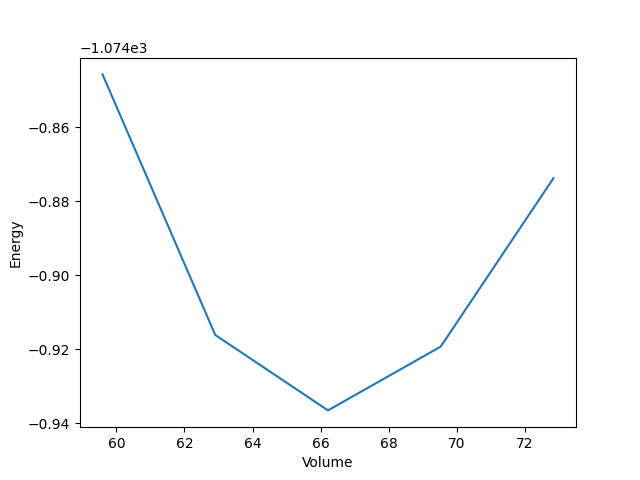

In [37]:
from IPython.display import Image, display

plot_task = [t for t in wg.tasks if t.name.startswith('plot_energy_volume_curve')][0]
plot_file = f"{plot_task.node.get_remote_workdir()}/evcurve.png"

display(Image(filename=str(plot_file)))
